**Import et dépendances**

In [66]:
!pip install python-Levenshtein

import pandas as pd
import numpy as np
import re
import math
from urllib.parse import urlparse
from datetime import datetime, timezone
from collections import Counter
from Levenshtein import distance as levenshtein_distance

import sys
if 'ipaddress' in sys.modules:
    del sys.modules['ipaddress']

**Drive**

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
import os
os.listdir("/content/drive/MyDrive/Dataset")


['phishing_data.csv',
 'benign_data.csv',
 'phishing.csv',
 'benign.csv',
 'phishing30k.csv',
 'benign30k.csv',
 'model_comparison.png',
 'best_phishing_model.pkl',
 'feature_scaler.pkl',
 'feature_names.pkl',
 'url_dns_best_model.joblib']

#  Configuration et Constantes



In [69]:
now = datetime.now(timezone.utc)

SENSITIVE_WORDS = [
    "login", "verify", "secure", "account", "update",
    "bank", "confirm", "password", "signin"
]

BRAND_WORDS = [
    "paypal", "google", "microsoft", "apple",
    "amazon", "facebook", "instagram"
]

COMMON_ISSUERS = [
    "let's encrypt",
    "google trust",
    "digicert",
    "globalsign",
    "sectigo",
    "amazon",
    "comodoca",
]


# Chemins vers les datasets
PHISHING_PATH = "/content/drive/MyDrive/Dataset/phishing30k.csv"
BENIGN_PATH = "/content/drive/MyDrive/Dataset/benign30k.csv"

#  Fonctions Utilitaires

Ces fonctions servent à :
1. **shannon_entropy** : Calculer l'entropie d'une chaîne (mesure du désordre/randomness)
2. **is_ip_address** : Détecter si un domaine est une adresse IP (technique de phishing courante)

In [70]:
def shannon_entropy(s):
    if not s or len(s) == 0:
        return 0
    probs = [s.count(c) / len(s) for c in set(s)]
    return -sum(p * math.log2(p) for p in probs)


def is_ip_address(domain):

    if not isinstance(domain, str) or domain == "":
        return 0

    ipv4_pattern = r'^(\d{1,3}\.){3}\d{1,3}$'
    if re.match(ipv4_pattern, domain):
        try:
            parts = domain.split('.')
            if all(0 <= int(p) <= 255 for p in parts):
                return 1
        except:
            pass

    if ':' in domain and re.match(r'^[0-9a-fA-F:]+$', domain):
        return 1

    return 0

#  Extraction des Features basées sur l'URL

Cette fonction extrait 13 features importantes depuis l'URL :
- Longueurs (URL totale, domaine, chemin, query string)
- Compteurs (sous-domaines, points, tirets, chiffres, caractères spéciaux)
- Indicateurs (présence de @, IP dans le domaine)
- Entropie de l'URL
- Présence de mots sensibles

In [71]:
def extract_url_features(url):

    if not isinstance(url, str):
        url = ""

    parsed = urlparse(url)
    domain = parsed.netloc

    return {
        "url_len": len(url),
        "domain_len": len(domain),
        "path_len": len(parsed.path),
        "query_len": len(parsed.query),
        "num_subdomains": max(0, domain.count(".") - 1),
        "num_dots": domain.count("."),
        "num_hyphens": domain.count("-"),
        "num_digits": sum(c.isdigit() for c in domain),
        "num_special_chars": sum(not c.isalnum() for c in domain),
        "has_at_symbol": int("@" in url),
        "has_ip_in_domain": is_ip_address(domain),
        "url_entropy": shannon_entropy(domain),
        "num_sensitive_words": sum(w in url.lower() for w in SENSITIVE_WORDS)
    }

#  Extraction des Features de Redirection



In [72]:
def extract_redirection_features(url, dest_url):

    try:
        if not isinstance(url, str) or not isinstance(dest_url, str):
            return {"dest_diff_domain": 0, "url_dest_levenshtein": 0}

        d1 = urlparse(url).netloc
        d2 = urlparse(dest_url).netloc

        return {
            "dest_diff_domain": int(d1 != d2),
            "url_dest_levenshtein": levenshtein_distance(d1, d2) if d1 and d2 else 0
        }
    except Exception:
        return {"dest_diff_domain": 0, "url_dest_levenshtein": 0}

#  Extraction des Features SSL/TLS



In [73]:
def extract_ssl_features(row, current_time):
    features = {
        "ssl_cert_age_days": 0,
        "ssl_cert_lifetime_days": 0,
        "ssl_issuer_is_common": 0
    }

    start = pd.to_datetime(row.get("ssl_valid_from"), utc=True, errors="coerce")
    end   = pd.to_datetime(row.get("ssl_valid_until"), utc=True, errors="coerce")

    if start is not pd.NaT and end is not pd.NaT:
        features["ssl_cert_age_days"] = max((current_time - start).days, 0)
        features["ssl_cert_lifetime_days"] = max((end - start).days, 0)

    issuer = str(row.get("ssl_issuer","")).lower()
    features["ssl_issuer_is_common"] = int(any(ci in issuer for ci in COMMON_ISSUERS))

    return features




#  Extraction des Features DNS


In [74]:
def extract_dns_features(row):

    a_status = str(row.get("dns_a_status", "")).upper()
    aaaa_status = str(row.get("dns_aaaa_status", "")).upper()
    mx_status = str(row.get("dns_mx_status", "")).upper()

    dns_has_a = int(a_status == "NOERROR")
    dns_has_aaaa = int(aaaa_status == "NOERROR")
    dns_has_mx = int(mx_status == "NOERROR")

    return {
        "dns_has_a": dns_has_a,
        "dns_has_aaaa": dns_has_aaaa,
        "dns_has_mx": dns_has_mx,
        "dns_complete": int(dns_has_a and dns_has_mx),
        "dns_is_suspicious": int(not dns_has_a and not dns_has_mx)
    }

# Extraction des Features ASN (Autonomous System Number)



In [75]:
def extract_asn_features(row, asn_freq):

    asn_code = row.get("maxmind_1_asn_code")
    return {
        "asn_present": int(pd.notna(asn_code)),
        "asn_freq_score": asn_freq.get(asn_code, 0) if pd.notna(asn_code) else 0,
        "cc_is_missing": int(pd.isna(row.get("maxmind_1_cc_code")))
    }

#  Extraction des Features du Titre de la Page



In [76]:
def extract_title_features(title, url):

    if not isinstance(title, str):
        title = ""
    if not isinstance(url, str):
        url = ""

    domain = urlparse(url).netloc.lower()

    return {
        "title_len": len(title),                                          # Longueur du titre
        "title_has_brand_words": int(any(b in title.lower() for b in BRAND_WORDS)),
        "title_has_sensitive_words": int(any(w in title.lower() for w in SENSITIVE_WORDS)),
        "title_is_upper": int(title.isupper()) if len(title) > 0 else 0,
        "title_url_mismatch": int(
            any(b in title.lower() for b in BRAND_WORDS) and
            not any(b in domain for b in BRAND_WORDS)
        )
    }

#  Construction de la Matrice de Features Complète



In [77]:
def build_features(df):

    print(f" Construction des features pour {len(df)} URLs...")
    feature_rows = []

    current_time = datetime.now(timezone.utc)

    asn_freq = Counter(df["maxmind_1_asn_code"].dropna())

    for idx, row in df.iterrows():
        try:
            features = {}

            features.update(extract_url_features(row.get("url", "")))
            features.update(extract_redirection_features(row.get("url", ""), row.get("destination_url", "")))
            features.update(extract_ssl_features(row, current_time))
            features.update(extract_dns_features(row))
            features.update(extract_asn_features(row, asn_freq))
            features.update(extract_title_features(row.get("title", ""), row.get("url", "")))

            features["is_https"] = int(row.get("is_https", False))
            features["ssl_is_valid_cert"] = int(row.get("ssl_is_valid_cert", False))

            feature_rows.append(features)

            if (idx + 1) % 5000 == 0:
                print(f" {idx + 1}/{len(df)} lignes traitées...")

        except Exception as e:
            print(f"Erreur à la ligne {idx}: {e}")
            if feature_rows:
                feature_rows.append({k: 0 for k in feature_rows[0].keys()})
            else:
                feature_rows.append({})

    print(f" Extraction des features terminée!")
    return pd.DataFrame(feature_rows).fillna(0)

## chargement des features utilisés en local pour l'inférence:


In [78]:
phishing = pd.read_csv(PHISHING_PATH)
benign = pd.read_csv(BENIGN_PATH)
phihing_url_dns_ssl=build_features(phishing)
benign_url_dns_ssl=build_features(benign)

 Construction des features pour 29591 URLs...
 5000/29591 lignes traitées...
 10000/29591 lignes traitées...
 15000/29591 lignes traitées...
Erreur à la ligne 16909: '𝕠𝕞𝕒𝕓𝕢𝕤𝕡.cn' does not appear to be an IPv4 or IPv6 address
Erreur à la ligne 17300: '𝕠𝕞𝕒𝕓𝕢𝕤𝕡.cn' does not appear to be an IPv4 or IPv6 address
 20000/29591 lignes traitées...
 25000/29591 lignes traitées...
 Extraction des features terminée!
 Construction des features pour 29999 URLs...
 5000/29999 lignes traitées...
 10000/29999 lignes traitées...
 15000/29999 lignes traitées...
 20000/29999 lignes traitées...
 25000/29999 lignes traitées...
 Extraction des features terminée!


#  Chargement et Préparation des Données

Nous chargeons les deux datasets :
- **phishing30k.csv** : URLs malveillantes
- **benign30k.csv** : URLs légitimes

Puis nous :
1. Ajoutons les labels (1 = phishing, 0 = benign)
2. Équilibrons les classes (même nombre de chaque)
3. Mélangeons aléatoirement pour éviter le biais

In [79]:
print(" CHARGEMENT DES DONNÉES")

phishing = pd.read_csv(PHISHING_PATH)
benign = pd.read_csv(BENIGN_PATH)

phishing["label"] = 1  # 1 = Phishing
benign["label"] = 0    # 0 = Benign

min_len = min(len(phishing), len(benign))
phishing = phishing.sample(min_len, random_state=42)
benign = benign.sample(min_len, random_state=42)

df = pd.concat([phishing, benign]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f" Dataset chargé: {df.shape}")
print(f"   - Phishing: {(df['label'] == 1).sum()}")
print(f"   - Benign: {(df['label'] == 0).sum()}")
print("\n Aperçu des données:")
print(df.head())

 CHARGEMENT DES DONNÉES
 Dataset chargé: (59182, 53)
   - Phishing: 29591
   - Benign: 29591

 Aperçu des données:
                                                 url  is_https dns_a_status  \
0  https://domotz.com/press/domotz-improves-the-c...      True      NOERROR   
1  https://redirect.splashtop.com/my/sos-commerci...      True      NOERROR   
2  https://business-facebocok-manager.bond/robots...      True      NOERROR   
3                          http://condecosftware.com     False      NOERROR   
4                  https://fr1wedu-a12a9.webflow.io/      True      NOERROR   

   dns_a_answer_1 dns_aaaa_status dns_mx_status             ssl_issuer  \
0   18.245.86.119         NOERROR       NOERROR                 Amazon   
1    76.223.35.50         NOERROR       NOERROR                 Amazon   
2  172.67.215.138         NOERROR       NOERROR  Google Trust Services   
3  185.53.179.170         NOERROR       NOERROR          Let's Encrypt   
4   151.101.2.188         NOERROR       

#  Extraction des Features du Dataset Complet

Nous appliquons maintenant toutes nos fonctions d'extraction sur l'ensemble du dataset.


In [80]:
print(" EXTRACTION DES FEATURES")

X = build_features(df)
y = df["label"].values

print(f"\n Matrice de features: {X.shape}")
print(f" Labels: {y.shape}")
print(f"\n Liste des features ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"   {i:2d}. {col}")

 EXTRACTION DES FEATURES
 Construction des features pour 59182 URLs...
 5000/59182 lignes traitées...
 10000/59182 lignes traitées...
 15000/59182 lignes traitées...
 20000/59182 lignes traitées...
 25000/59182 lignes traitées...
Erreur à la ligne 29254: '𝕠𝕞𝕒𝕓𝕢𝕤𝕡.cn' does not appear to be an IPv4 or IPv6 address
 30000/59182 lignes traitées...
 35000/59182 lignes traitées...
 40000/59182 lignes traitées...
 45000/59182 lignes traitées...
Erreur à la ligne 47726: '𝕠𝕞𝕒𝕓𝕢𝕤𝕡.cn' does not appear to be an IPv4 or IPv6 address
 50000/59182 lignes traitées...
 55000/59182 lignes traitées...
 Extraction des features terminée!

 Matrice de features: (59182, 33)
 Labels: (59182,)

 Liste des features (33):
    1. url_len
    2. domain_len
    3. path_len
    4. query_len
    5. num_subdomains
    6. num_dots
    7. num_hyphens
    8. num_digits
    9. num_special_chars
   10. has_at_symbol
   11. has_ip_in_domain
   12. url_entropy
   13. num_sensitive_words
   14. dest_diff_domain
   15. url_des

#  Analyse Statistique des Features

Visualisons les statistiques descriptives de nos 33 features extraites




In [81]:
print(" STATISTIQUES DESCRIPTIVES")

X.describe().T

 STATISTIQUES DESCRIPTIVES


,count,mean,std,min,25%,50%,75%,max
url_len,59182.0,47.829915,54.859895,0.0,29.000000,37.000000,55.000000,6798.000000
domain_len,59182.0,18.641428,9.120800,0.0,12.000000,17.000000,23.000000,132.000000
path_len,59182.0,16.905410,28.684099,0.0,1.000000,7.000000,22.000000,2073.000000
query_len,59182.0,4.188132,45.828505,0.0,0.000000,0.000000,0.000000,6762.000000
num_subdomains,59182.0,0.651347,0.577597,0.0,0.000000,1.000000,1.000000,6.000000
num_dots,59182.0,1.651313,0.577665,0.0,1.000000,2.000000,2.000000,7.000000
num_hyphens,59182.0,0.332111,0.888709,0.0,0.000000,0.000000,0.000000,16.000000
num_digits,59182.0,0.615474,2.097118,0.0,0.000000,0.000000,0.000000,48.000000
num_special_chars,59182.0,1.989794,1.165318,0.0,1.000000,2.000000,2.000000,19.000000
has_at_symbol,59182.0,0.003346,0.057745,0.0,0.000000,0.000000,0.000000,1.000000


###  Visualisation de la Matrice de Corrélation des Features



 MATRICE DE CORRÉLATION DES FEATURES


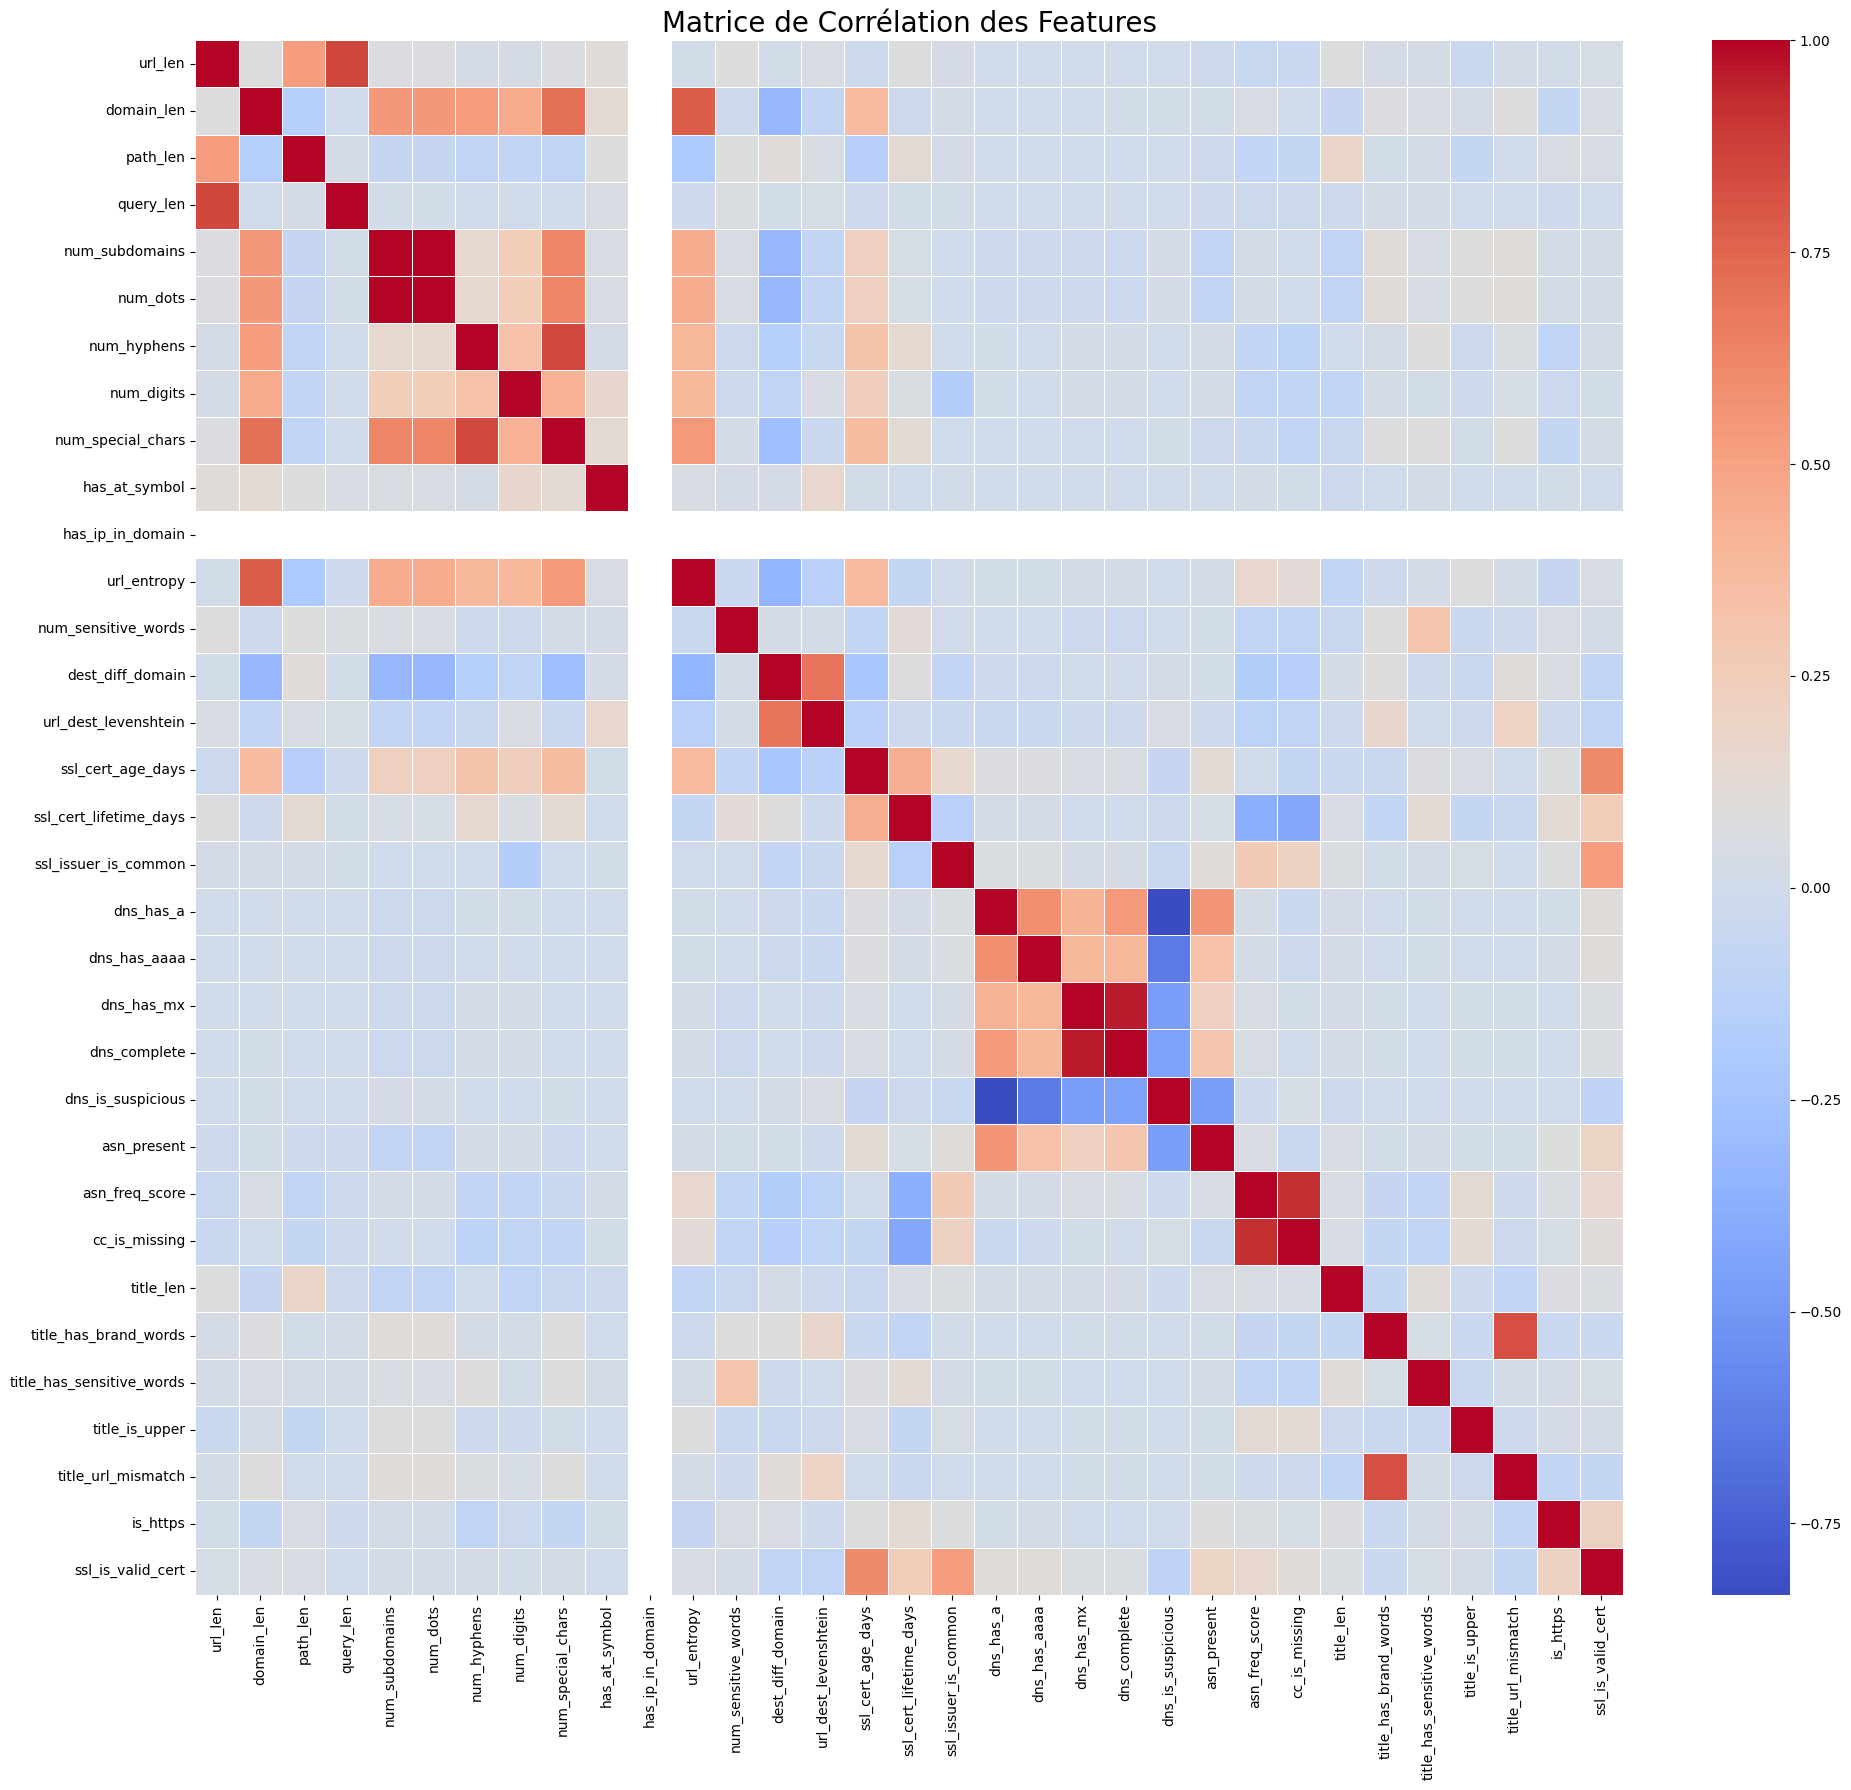

 Matrice de corrélation affichée.


In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

print(" MATRICE DE CORRÉLATION DES FEATURES")

correlation_matrix = X.corr()

plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de Corrélation des Features', fontsize=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(" Matrice de corrélation affichée.")

###  Visualisation de la Matrice de Corrélation des Features (avec label)



 MATRICE DE CORRÉLATION DES FEATURES AVEC LABEL


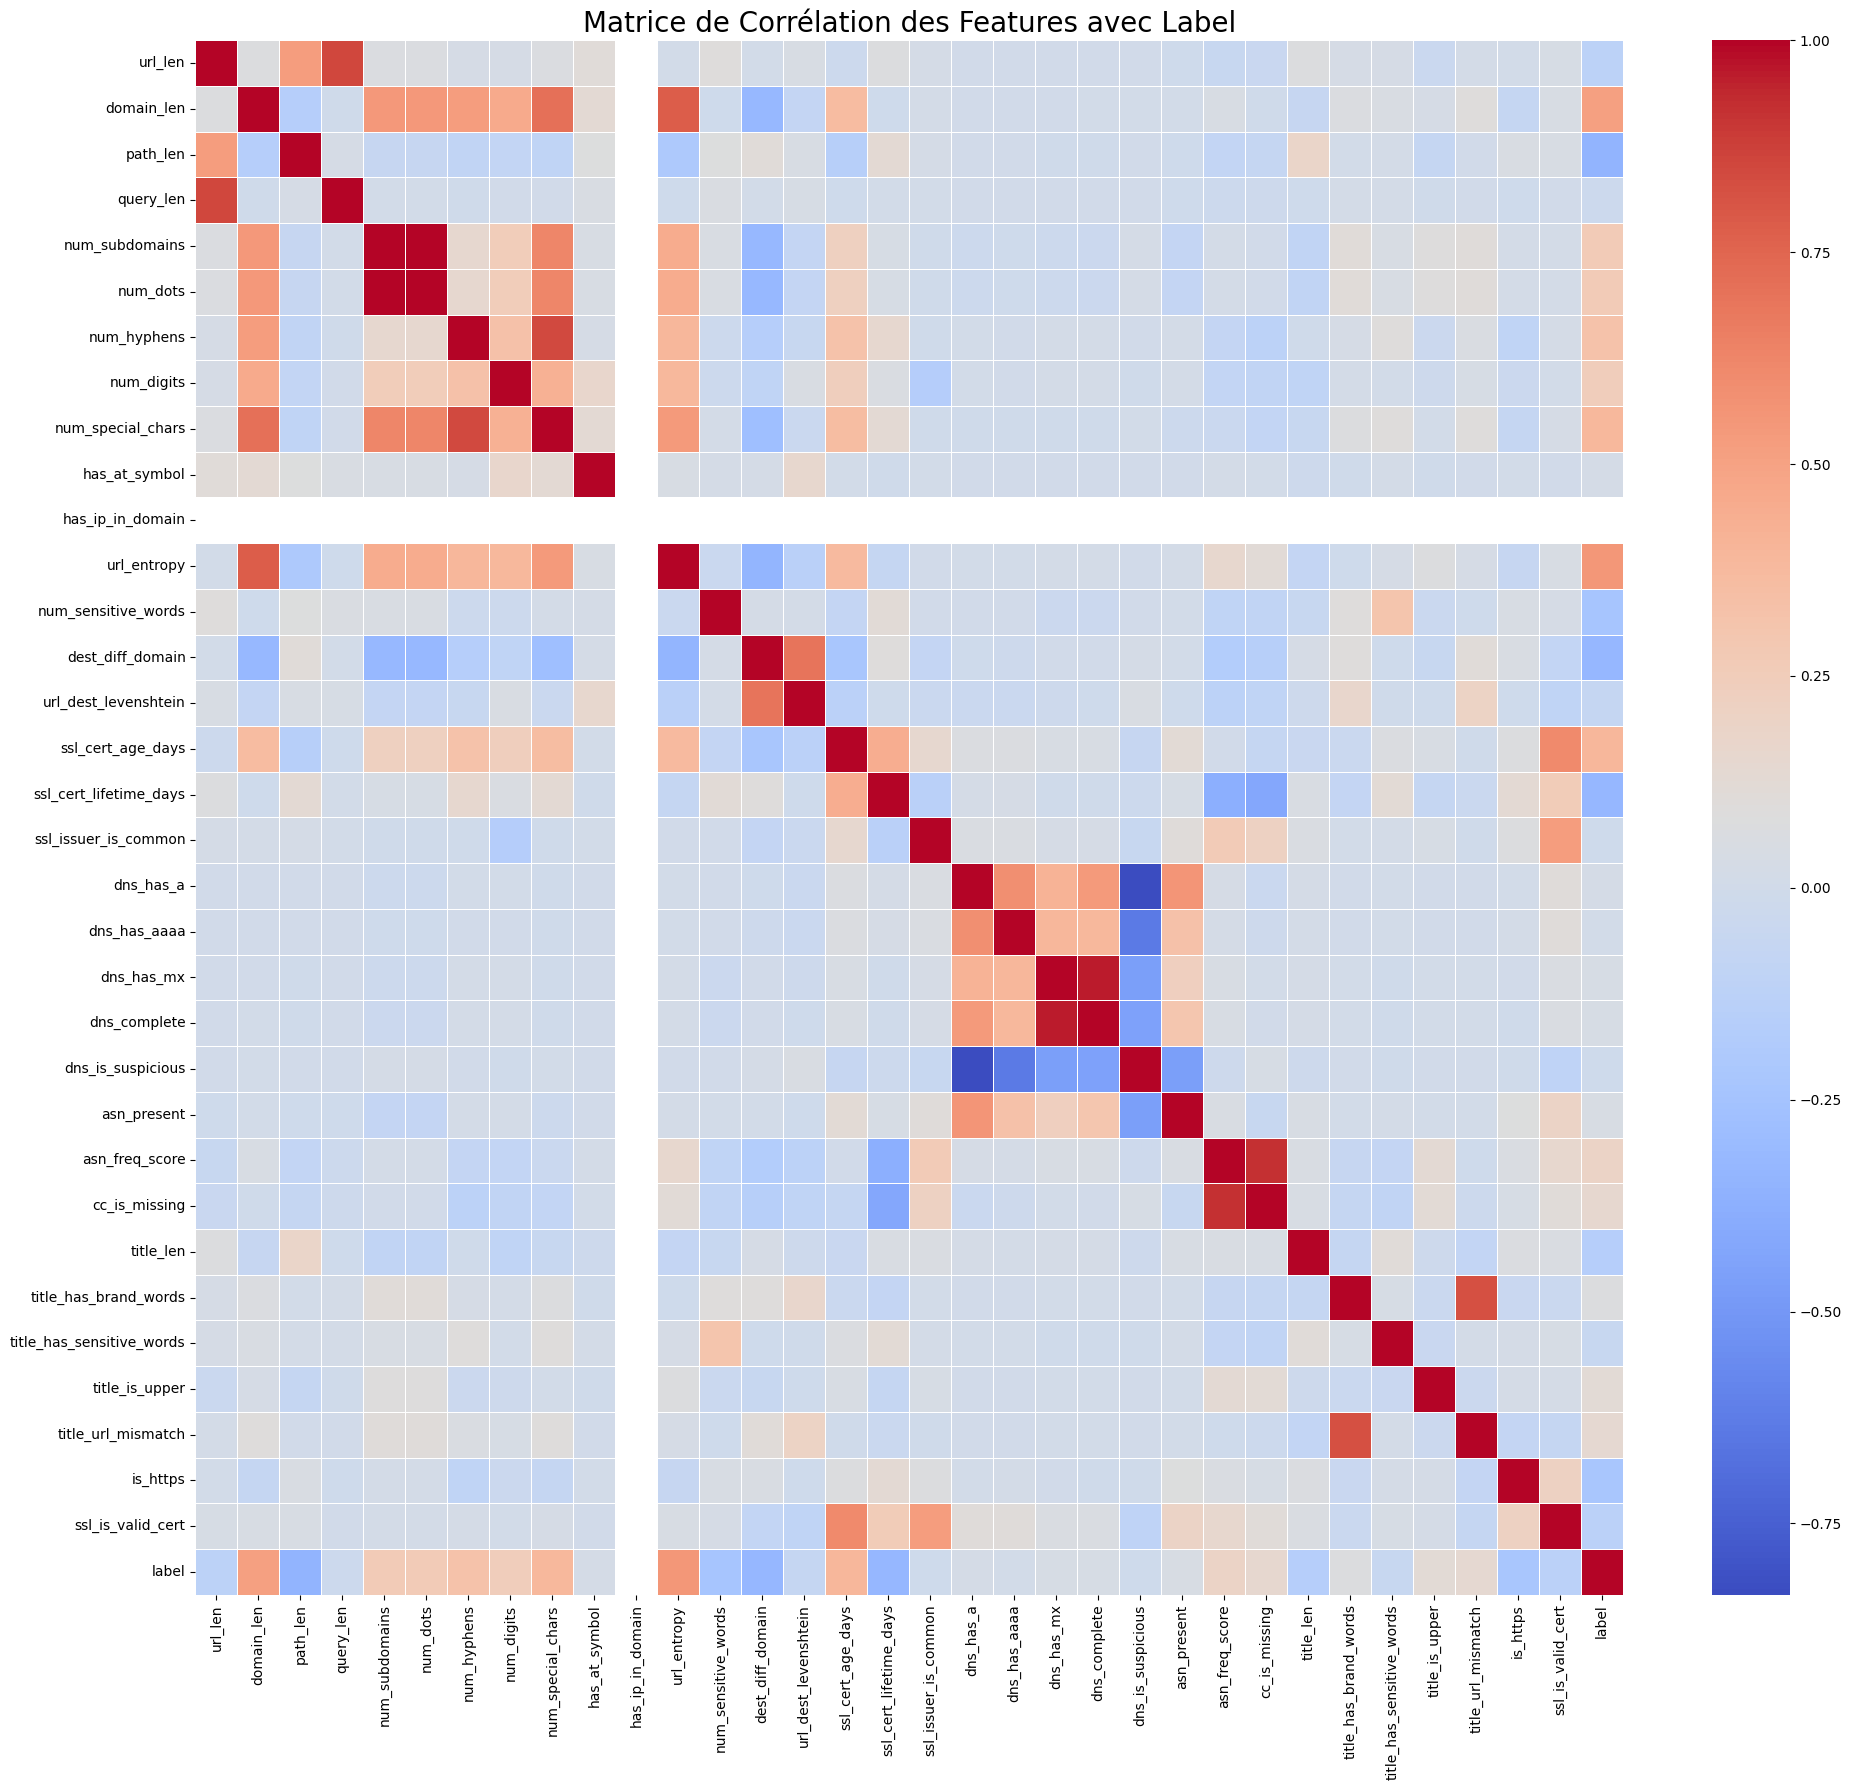

 Matrice de corrélation avec label affichée.


In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print(" MATRICE DE CORRÉLATION DES FEATURES AVEC LABEL")

df_with_labels = X.copy()
df_with_labels['label'] = y

correlation_matrix_with_labels = df_with_labels.corr()

plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix_with_labels, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de Corrélation des Features avec Label', fontsize=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(" Matrice de corrélation avec label affichée.")

#  Préparation du Machine Learning


In [84]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime

#  Division Train/Test et Standardisation

**Split stratifié 80/20**


**Standardisation**


In [85]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print(" SPLIT DES DONNÉES")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f" Train set: {X_train.shape[0]} samples")
print(f" Test set:  {X_test.shape[0]} samples")
print(f"   - Phishing train: {(y_train == 1).sum()}")
print(f"   - Benign train:   {(y_train == 0).sum()}")
print(f"   - Phishing test:  {(y_test == 1).sum()}")
print(f"   - Benign test:    {(y_test == 0).sum()}")

print("\n Standardisation des features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(" Standardisation terminée!")

 SPLIT DES DONNÉES
 Train set: 47345 samples
 Test set:  11837 samples
   - Phishing train: 23673
   - Benign train:   23672
   - Phishing test:  5918
   - Benign test:    5919

 Standardisation des features...
 Standardisation terminée!


#  Configuration des Modèles à Entraîner

Nous allons comparer **5 algorithmes** de classification :

1. **Logistic Regression**
2. **Random Forest**
3. **Gradient Boosting**
4. **XGBoost**
5. **LightGBM**



In [86]:
print(" CONFIGURATION DES MODÈLES")

models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        random_state=42
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        eval_metric='logloss'
    ),

    "LightGBM": LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        verbose=-1
    )
}

print(f" {len(models)} modèles configurés et prêts à l'entraînement")

 CONFIGURATION DES MODÈLES
 5 modèles configurés et prêts à l'entraînement


#  Entraînement et Évaluation des Modèles


In [87]:
results = {}

for name, model in models.items():
    print(f"\n Entraînement: {name}...")
    start_time = datetime.now()

    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)


    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'training_time': training_time,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"    Terminé en {training_time:.2f}s")
    print(f"    Accuracy:  {accuracy:.4f}")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall:    {recall:.4f}")
    print(f"    F1-Score:  {f1:.4f}")
    print(f"    ROC-AUC:   {roc_auc:.4f}")


 Entraînement: Logistic Regression...
    Terminé en 0.81s
    Accuracy:  0.9850
    Precision: 0.9845
    Recall:    0.9855
    F1-Score:  0.9850
    ROC-AUC:   0.9958

 Entraînement: Random Forest...
    Terminé en 3.31s
    Accuracy:  0.9973
    Precision: 0.9990
    Recall:    0.9956
    F1-Score:  0.9973
    ROC-AUC:   0.9999

 Entraînement: Gradient Boosting...
    Terminé en 13.59s
    Accuracy:  0.9971
    Precision: 0.9978
    Recall:    0.9965
    F1-Score:  0.9971
    ROC-AUC:   0.9999

 Entraînement: XGBoost...
    Terminé en 0.70s
    Accuracy:  0.9973
    Precision: 0.9980
    Recall:    0.9966
    F1-Score:  0.9973
    ROC-AUC:   0.9999

 Entraînement: LightGBM...
    Terminé en 0.80s
    Accuracy:  0.9973
    Precision: 0.9981
    Recall:    0.9965
    F1-Score:  0.9973
    ROC-AUC:   0.9999


In [88]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from datetime import datetime
import numpy as np

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

scoring = {
    "f1": "f1",
    "roc_auc": "roc_auc"
}

results = {}

for name, model in models.items():
    print(f"\n Entraînement (CV): {name}...")
    start_time = datetime.now()

    if name == "Logistic Regression":
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train
        X_te = X_test

    cv_results = cross_validate(
        model,
        X_tr,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )

    cv_f1_mean = np.mean(cv_results["test_f1"])
    cv_roc_auc_mean = np.mean(cv_results["test_roc_auc"])

    model.fit(X_tr, y_train)

    y_pred = model.predict(X_te)
    y_pred_proba = model.predict_proba(X_te)[:, 1]

    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)


    results[name] = {
        "model": model,
        "cv_f1": cv_f1_mean,
        "cv_roc_auc": cv_roc_auc_mean,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "training_time": training_time,
        "y_pred": y_pred,
        "y_pred_proba": y_pred_proba
    }

    print(f"    Time: {training_time:.2f}s")
    print(f"    CV F1:       {cv_f1_mean:.4f}")
    print(f"    CV ROC-AUC:  {cv_roc_auc_mean:.4f}")
    print(f"    Test F1:     {f1:.4f}")
    print(f"    Test ROC-AUC:{roc_auc:.4f}")



 Entraînement (CV): Logistic Regression...
    Time: 0.96s
    CV F1:       0.9856
    CV ROC-AUC:  0.9969
    Test F1:     0.9850
    Test ROC-AUC:0.9958

 Entraînement (CV): Random Forest...
    Time: 16.12s
    CV F1:       0.9967
    CV ROC-AUC:  0.9999
    Test F1:     0.9973
    Test ROC-AUC:0.9999

 Entraînement (CV): Gradient Boosting...
    Time: 59.47s
    CV F1:       0.9969
    CV ROC-AUC:  0.9999
    Test F1:     0.9971
    Test ROC-AUC:0.9999

 Entraînement (CV): XGBoost...
    Time: 5.48s
    CV F1:       0.9967
    CV ROC-AUC:  0.9999
    Test F1:     0.9973
    Test ROC-AUC:0.9999

 Entraînement (CV): LightGBM...
    Time: 3.74s
    CV F1:       0.9970
    CV ROC-AUC:  0.9999
    Test F1:     0.9973
    Test ROC-AUC:0.9999


In [89]:
from joblib import dump, load
import os

model_save_dir = '/content/drive/MyDrive/Dataset'
os.makedirs(model_save_dir, exist_ok=True)

if 'LightGBM' in results and 'model' in results['LightGBM']:
    clf_lgbm = results['LightGBM']['model']
    dump(clf_lgbm, os.path.join(model_save_dir, 'url_dns_best_model.joblib'))
    print(f" LightGBM model saved to: {os.path.join(model_save_dir, 'url_dns_best_model.joblib')}")
else:
    print(" LightGBM model not found in results.")

 LightGBM model saved to: /content/drive/MyDrive/Dataset/url_dns_best_model.joblib


###  Charger les Modèles et Artefacts Sauvegardés

Nous allons charger le meilleur modèle (XGBoost), le `StandardScaler` et la liste des noms des features que nous avons sauvegardés précédemment.

In [90]:
import pickle
import os
import pandas as pd

model_save_dir = '/content/drive/MyDrive/Dataset'

model_path = os.path.join(model_save_dir, 'best_phishing_model.pkl')
with open(model_path, 'rb') as f:
    loaded_model = pickle.load(f)
print(f" Modèle '{loaded_model.__class__.__name__}' chargé depuis: {model_path}")

scaler_path = os.path.join(model_save_dir, 'feature_scaler.pkl')
with open(scaler_path, 'rb') as f:
    loaded_scaler = pickle.load(f)
print(f" Scaler chargé depuis: {scaler_path}")

feature_names_path = os.path.join(model_save_dir, 'feature_names.pkl')
with open(feature_names_path, 'rb') as f:
    loaded_feature_names = pickle.load(f)
print(f" Noms des features chargés depuis: {feature_names_path}")


 Modèle 'XGBClassifier' chargé depuis: /content/drive/MyDrive/Dataset/best_phishing_model.pkl
 Scaler chargé depuis: /content/drive/MyDrive/Dataset/feature_scaler.pkl
 Noms des features chargés depuis: /content/drive/MyDrive/Dataset/feature_names.pkl


###  Faire une Prédiction sur une Nouvelle URL

Pour faire une prédiction sur une nouvelle URL, vous devez suivre les mêmes étapes que celles utilisées lors de l'entraînement:

1.  **Construire un DataFrame** avec les données brutes de la nouvelle URL (au minimum, l'URL elle-même, mais aussi d'autres informations si disponibles comme l'URL de destination, le titre, etc., afin que toutes les features puissent être extraites).
2.  **Extraire les features** en utilisant la fonction `build_features` que nous avons définie plus tôt.
3.  **Appliquer le même scaler** (`loaded_scaler`) pour transformer les features.
4.  **Utiliser le modèle chargé** (`loaded_model`) pour obtenir la prédiction.

In [91]:
from datetime import datetime, timezone
from collections import Counter
import pandas as pd

# Données des nouvelles URLs
new_urls_data = [
    {
        'url': 'https://www.google.com/search?q=hello',
        'destination_url': 'https://www.google.com/search?q=hello',
        'ssl_valid_from': '2023-01-01', 'ssl_valid_until': '2024-01-01', 'ssl_issuer': 'Google Trust Services',
        'dns_a_status': 'NOERROR', 'dns_aaaa_status': 'NOERROR', 'dns_mx_status': 'NOERROR',
        'maxmind_1_asn_code': 15169, 'maxmind_1_cc_code': 'US',
        'title': 'Google',
        'is_https': True, 'ssl_is_valid_cert': True
    },
    {
        'url': 'http://paypal-login-verify.com/update-account/index.php',
        'destination_url': 'http://paypal-login-verify.com/update-account/index.php',
        'ssl_valid_from': None, 'ssl_valid_until': None, 'ssl_issuer': None,
        'dns_a_status': 'NOERROR', 'dns_aaaa_status': 'NXDOMAIN', 'dns_mx_status': 'NXDOMAIN',
        'maxmind_1_asn_code': None, 'maxmind_1_cc_code': None,
        'title': 'PayPal Account Login',
        'is_https': False, 'ssl_is_valid_cert': False
    },
    {
        'url': 'https://s.id/1xO7X',
        'destination_url': 'https://example.com/malicious-site',
        'ssl_valid_from': '2024-06-01', 'ssl_valid_until': '2024-09-01', 'ssl_issuer': "Let's Encrypt",
        'dns_a_status': 'NOERROR', 'dns_aaaa_status': 'NOERROR', 'dns_mx_status': 'NOERROR',
        'maxmind_1_asn_code': 13335, 'maxmind_1_cc_code': 'US',
        'title': 'Login to Your Account',
        'is_https': True, 'ssl_is_valid_cert': True
    }
]

for url_data in new_urls_data:
    if url_data['ssl_valid_from'] is not None:
        url_data['ssl_valid_from'] = pd.to_datetime(url_data['ssl_valid_from']).tz_localize('UTC')
    if url_data['ssl_valid_until'] is not None:
        url_data['ssl_valid_until'] = pd.to_datetime(url_data['ssl_valid_until']).tz_localize('UTC')

new_df = pd.DataFrame(new_urls_data)


asn_freq_for_new_data = Counter(df["maxmind_1_asn_code"].dropna())

def build_features_for_single_row(row, current_time, asn_freq_counter):
    features = {}
    features.update(extract_url_features(row.get("url", "")))
    features.update(extract_redirection_features(row.get("url", ""), row.get("destination_url", "")))
    features.update(extract_ssl_features(row, current_time))
    features.update(extract_dns_features(row))
    features.update(extract_asn_features(row, asn_freq_counter))
    features.update(extract_title_features(row.get("title", ""), row.get("url", "")))
    features["is_https"] = int(row.get("is_https", False))
    features["ssl_is_valid_cert"] = int(row.get("ssl_is_valid_cert", False))
    return features

current_time = datetime.now(timezone.utc)

new_features_list = [build_features_for_single_row(row, current_time, asn_freq_for_new_data)
                     for _, row in new_df.iterrows()]
new_X = pd.DataFrame(new_features_list)


new_X = new_X.reindex(columns=loaded_feature_names, fill_value=0)

new_X_scaled = loaded_scaler.transform(new_X)

predictions = loaded_model.predict(new_X_scaled)
prediction_proba = loaded_model.predict_proba(new_X_scaled)[:, 1]

print("\n--- Prédictions pour les nouvelles URLs ---")
for i, url_data in enumerate(new_urls_data):
    status = "Phishing" if predictions[i] == 1 else "Benign"
    print(f"URL: {url_data['url']}")
    print(f"  Prédiction: {status} (Confiance: {prediction_proba[i]:.4f})")
    print("------------------------------------------")


--- Prédictions pour les nouvelles URLs ---
URL: https://www.google.com/search?q=hello
  Prédiction: Phishing (Confiance: 0.8974)
------------------------------------------
URL: http://paypal-login-verify.com/update-account/index.php
  Prédiction: Phishing (Confiance: 0.5824)
------------------------------------------
URL: https://s.id/1xO7X
  Prédiction: Benign (Confiance: 0.1489)
------------------------------------------


#  Comparaison des performances des modèles

Cette section présente une **comparaison détaillée des performances** des différents modèles de classification entraînés pour la détection de sites de phishing.




 COMPARAISON DES MODÈLES
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Training Time (s)
            XGBoost  0.997297   0.997970 0.996620  0.997295 0.999930           5.479585
           LightGBM  0.997297   0.998138 0.996452  0.997294 0.999936           3.740761
      Random Forest  0.997297   0.998983 0.995607  0.997292 0.999941          16.124762
  Gradient Boosting  0.997128   0.997800 0.996452  0.997125 0.999916          59.473040
Logistic Regression  0.984962   0.984470 0.985468  0.984969 0.995774           0.955499

 MEILLEUR MODÈLE: XGBoost
 VISUALISATIONS : 
 Graphiques sauvegardés: /content/drive/MyDrive/Dataset/model_comparison.png


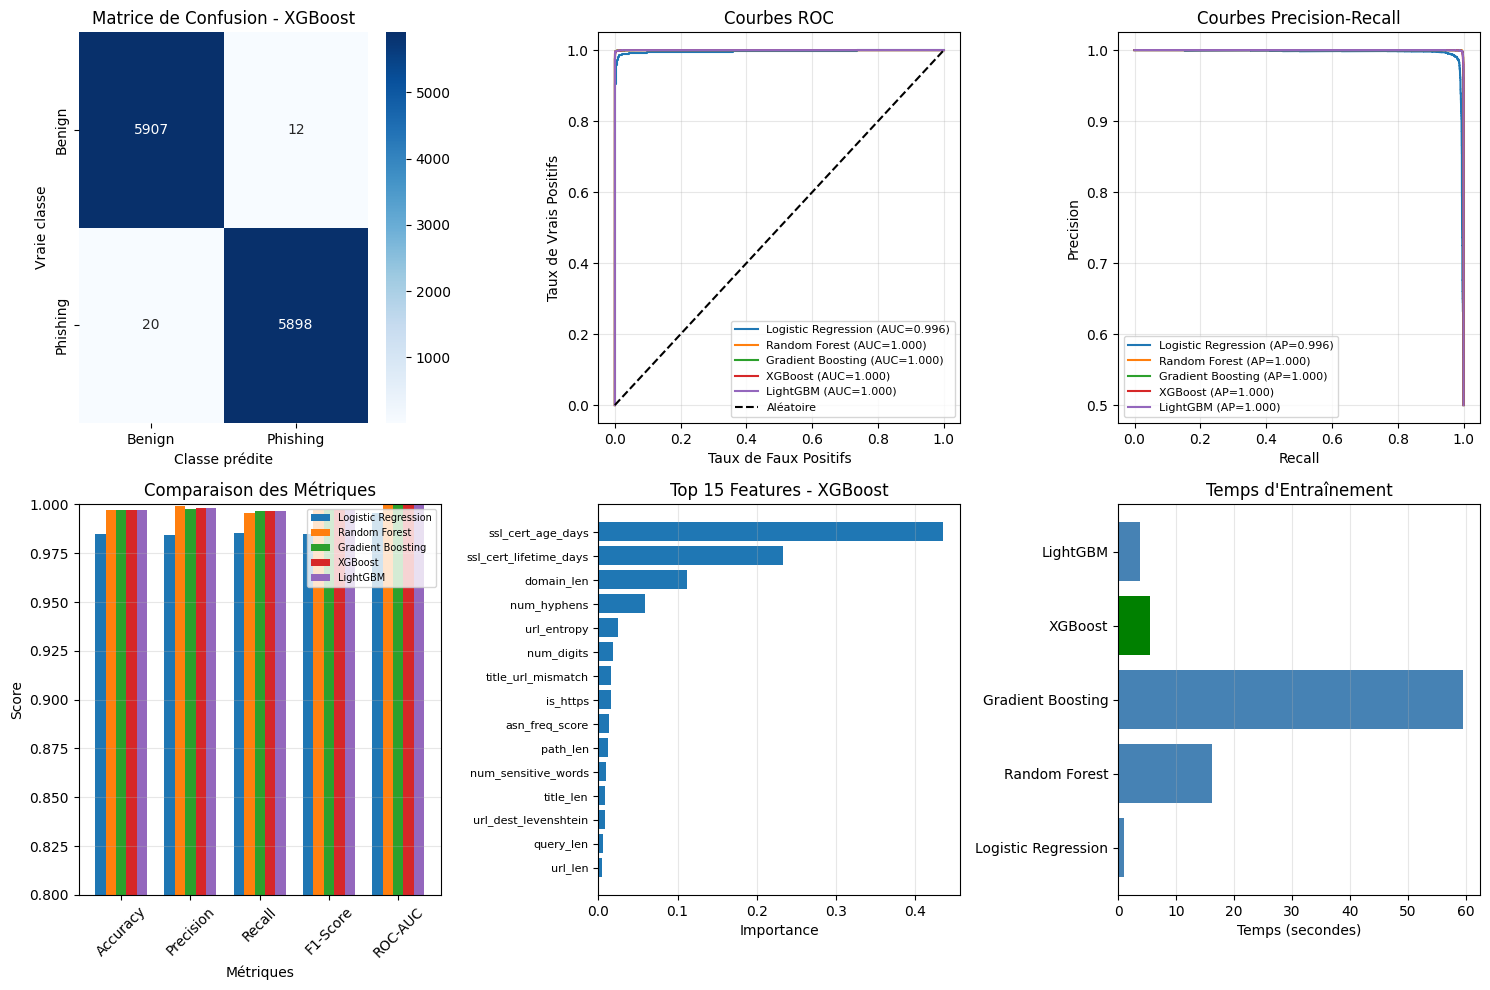

 SAUVEGARDE DU MEILLEUR MODÈLE
 Modèle sauvegardé: /content/drive/MyDrive/Dataset/best_phishing_model.pkl
 Scaler sauvegardé: /content/drive/MyDrive/Dataset/feature_scaler.pkl
 Noms des features sauvegardés: /content/drive/MyDrive/Dataset/feature_names.pkl


In [92]:
print(" COMPARAISON DES MODÈLES")

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [r['accuracy'] for r in results.values()],
    'Precision': [r['precision'] for r in results.values()],
    'Recall': [r['recall'] for r in results.values()],
    'F1-Score': [r['f1'] for r in results.values()],
    'ROC-AUC': [r['roc_auc'] for r in results.values()],
    'Training Time (s)': [r['training_time'] for r in results.values()]
})

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
print(comparison_df.to_string(index=False))

best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\n MEILLEUR MODÈLE: {best_model_name}")

#
print(" VISUALISATIONS : ")

# 1. Matrice de confusion pour le meilleur modèle
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Phishing'],
            yticklabels=['Benign', 'Phishing'])
plt.title(f'Matrice de Confusion - {best_model_name}')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')

# 2. Courbe ROC
plt.subplot(2, 3, 2)
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={result['roc_auc']:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbes ROC')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)

# 3. Precision-Recall Curve
plt.subplot(2, 3, 3)
for name, result in results.items():
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, result['y_pred_proba'])
    avg_precision = average_precision_score(y_test, result['y_pred_proba'])
    plt.plot(recall_curve, precision_curve, label=f"{name} (AP={avg_precision:.3f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbes Precision-Recall')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)

# 4. Comparaison des métriques
plt.subplot(2, 3, 4)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.15

for i, (name, result) in enumerate(results.items()):
    values = [result['accuracy'], result['precision'], result['recall'],
              result['f1'], result['roc_auc']]
    plt.bar(x + i*width, values, width, label=name)

plt.xlabel('Métriques')
plt.ylabel('Score')
plt.title('Comparaison des Métriques')
plt.xticks(x + width*2, metrics, rotation=45)
plt.legend(fontsize=7)
plt.ylim(0.8, 1.0)
plt.grid(True, alpha=0.3, axis='y')

# 5. Feature Importance
plt.subplot(2, 3, 5)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[-15:]  # Top 15

    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [X.columns[i] for i in indices], fontsize=8)
    plt.xlabel('Importance')
    plt.title(f'Top 15 Features - {best_model_name}')
    plt.grid(True, alpha=0.3, axis='x')
else:
    plt.text(0.5, 0.5, 'Feature importance\nnon disponible\npour ce modèle',
             ha='center', va='center', fontsize=12)
    plt.axis('off')

# 6. Temps d'entraînement
plt.subplot(2, 3, 6)
training_times = [r['training_time'] for r in results.values()]
model_names = list(results.keys())
colors = ['green' if name == best_model_name else 'steelblue' for name in model_names]
plt.barh(model_names, training_times, color=colors)
plt.xlabel('Temps (secondes)')
plt.title('Temps d\'Entraînement')
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()

model_save_dir = '/content/drive/MyDrive/Dataset'
os.makedirs(model_save_dir, exist_ok=True)

image_path = os.path.join(model_save_dir, 'model_comparison.png')
plt.savefig(image_path, dpi=300, bbox_inches='tight')
print(f" Graphiques sauvegardés: {image_path}")
plt.show()


print(" SAUVEGARDE DU MEILLEUR MODÈLE")

model_path = os.path.join(model_save_dir, 'best_phishing_model.pkl')
scaler_path = os.path.join(model_save_dir, 'feature_scaler.pkl')

with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f" Modèle sauvegardé: {model_path}")

with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f" Scaler sauvegardé: {scaler_path}")

feature_names_path = os.path.join(model_save_dir, 'feature_names.pkl')
with open(feature_names_path, 'wb') as f:
    pickle.dump(list(X.columns), f)
print(f" Noms des features sauvegardés: {feature_names_path}")


